# PyHSMM Experiment - Template

This notebook provides all functionalities to run experiments with the updated version of the pyhsmm package (originally from `matjj`). 

---

## 0. Setup of the Environment

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhsmm.basic.distributions import PoissonDuration, NegativeBinomialDuration, NegativeBinomialFixedRDuration
from pyhsmm.models import WeakLimitHDPHSMM, HSMM
from pybasicbayes.distributions.gaussian import Gaussian
from pybasicbayes.distributions.multinomial import Categorical
from pybasicbayes.distributions.mixturedistribution import DistributionMixture
import pickle
from pyhsmm.util.eaf_processing import to_eaf
import random
import sys
import ipywidgets as widgets
import datetime

sys.path.insert(1,'/home/daniel/PycharmProjects/virtamed')

from helpers import get_list_of_files, load_zipped_pickle

np.random.seed(1001)
random.seed(1001)

---

## 1. Read in data

The data is assumed to be prepared and stored in zipped pickle files. Refer to the `virtamed` project for more information.

In [2]:
def read_data_from_disk(root_dir, limit=None):
    file_list = get_list_of_files(root_dir)
    obs_array = []
    records = []
    data_frames = []
    eaf_fnames = []
    for fname in file_list:
        print('Got data for ' + fname)
        data_dict = load_zipped_pickle(fname)
        obs_array.append(data_dict['obs'])
        records.append(data_dict['record'])
        data_frames.append(data_dict['decode_df'])
        eaf_fnames.append(data_dict['eaf_path'])
    
    return obs_array, records, data_frames, eaf_fnames

We will use the data that has been obtained preprocessed.

In [3]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_13_14_48_287.zip
Got data for /home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_pyhsmm_data/pyhsmm_data/2018_01_18_13_18_40_675.zip
Got data for /home/daniel/P

---

## 2. Experiments

###  2a. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 2a. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [5]:
obs_dim = 5
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

#### 2a. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [6]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Dirichlet prior can be seen as pseudo counts that are seen for every state transition.
# The larger we set the dirichlet prior parameter alpha the less our likelihood will influence the posterior
# and the more the individual distributions of transitioning from one fixed state into any other will tend to
# a uniform distribution

# Note that theoretically for a valid HSMM the probability of remaining in the same state should be 0 at all times.
# We need to check if the given implementation takes that into account.

dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 2a. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [7]:

init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

init_state_dirichlet_prior = 1

#### 2a. iv) Duration distribution model initialization

We will now initialize the parameter of the state-specific duration distribution model. Note that the implementation so far only support Poisson distributions and negative binomial distributions.

We will now provide the hyper-parameters of a Poisson distribution as well as the respective Gamma priors for the individual states.

The values are chosen in such a way that the MAP of the first and second moment are close to what we assume a good initial guess of the individual durations of the specific states. Our assumption is based on what we have observed in the annotated sequence 692.

In [8]:
#duration_gamma_prior_alpha_0s = [250.0*2, 20.0*2, 20.0*2, 20.0*2, 20.0*2, 150.0*2]
duration_gamma_prior_alpha_0s = [0,0,0,0,0,0]
duration_gamma_prior_alpha_0s = np.array(duration_gamma_prior_alpha_0s)
duration_gamma_prior_beta_0s = [2, 2, 2, 2, 2, 2]
duration_gamma_prior_beta_0s = np.array(duration_gamma_prior_beta_0s)

duration_poission_lmbda = [275, 30, 30, 30, 30, 150]
duration_poission_lmbda = np.array(duration_poission_lmbda).astype(np.int64)

Alternatively, we can use a Negative Binomial distribution to model the durations.

In [9]:
duration_negbin_r_gamma_prior_k = np.array([1,1,1,1,1,1,1])
duration_negbin_r_gamma_prior_theta = np.array([1,1,1,1,1,1])

duration_negbin_p_beta_prior_alpha=np.array([1,1,1,1,1,1])
duration_negbin_p_beta_prior_beta=np.array([1,1,1,1,1,1])

duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

# # Beta prior for p
# alpha_0s = [0.9982, 0.9992, 0.99982, 0.99982, 0.997, 0.9988]
# beta_0s = []
# for alpha_0 in alpha_0s:
#     beta_0s.append(1 - alpha_0)
#
# p_s = np.array([0.9982, 0.9992, 0.99982, 0.99982, 0.97, 0.9988])
# r_s = np.array([0.811, 0.160, 0.0056, 0.0056, 0.09, 0.3604])
#
# # Gamma prior for r
# theta_0s = np.array([0.811, 0.160, 0.09, 0.0056, 0.09, 0.3604])
# k_0s = np.array([1, 1, 1, 1, 1, 1])


#### 2a. v) Continuous emission model

After having defined the parameter for all models except for the emission model, we will now first define those of the emission model for the continuous emission symbols. The intiailization is copied form the one used in the experiments conducted in the `virtamed` package. Additional we define the an Inverse-Wishart prior for the distribution. The choice of the hyperparemeters of the latter are chosen rather arbitrary at the time being.

In [10]:
# emission means
cont_emission_mu_0s = [[0.88642484,-0.00891672,-0.04283354,-0.0317823],[0.61224319,0.02817965,-0.02589644,-0.04455821],[0.58584866,-0.00769866,0.02885823,0.04061716],[0.43383527,0.18540008,0.04765909,-0.07190584],[0.30027241,-0.03101967,-0.02387799,0.02523613],[0.12876249,-0.05194618,0.1515244,0.0675104]]
cont_emission_mu_0s = np.array(cont_emission_mu_0s)

# emission covariances
cont_emission_sigma_0s = [[[5.43564900e-02,-1.02311669e-03,-1.20809601e-02,-1.02502021e-03],[-1.02311669e-03,5.83729890e-01,2.19925787e-02,-1.75695080e-03],[-1.20809601e-02,2.19925787e-02,1.71378102e-01,5.04926024e-02],[-1.02502021e-03,-1.75695080e-03,5.04926024e-02,3.42755585e-01]],[[6.83205801e-02,-5.67017463e-03,-4.17238835e-03,-9.87379049e-03],[-5.67017463e-03,1.58531968e-01,1.63952434e-02,1.22384808e-02],[-4.17238835e-03,1.63952434e-02,9.99248104e-02,1.37774898e-02],[-9.87379049e-03,1.22384808e-02,1.37774898e-02,1.54694142e-01]],[[5.86630217e-02,5.64290457e-04,-6.46090277e-04,-1.49891494e-03],[5.64290457e-04,6.01453893e-02,-2.73922290e-04,-1.74955950e-03],[-6.46090277e-04,-2.73922290e-04,5.11560030e-02,-7.84147526e-04],[-1.49891494e-03,-1.74955950e-03,-7.84147526e-04,6.93725893e-02]],[[5.91858857e-02,-8.20626778e-03,-6.06608823e-04,3.79264532e-03],[-8.20626778e-03,1.66771745e-01,6.32176840e-03,-3.02101347e-02],[-6.06608823e-04,6.32176840e-03,5.09901883e-02,-1.26116808e-03],[3.79264532e-03,-3.02101347e-02,-1.26116808e-03,6.39967215e-02]],[[8.61065728e-02,6.40796793e-04,-4.24814451e-03,1.11548464e-02],[6.40796793e-04,3.05070604e-01,-3.19118389e-02,-1.17706617e-02],[-4.24814451e-03,-3.19118389e-02,1.36628271e-01,-1.18966409e-02],[1.11548464e-02,-1.17706617e-02,-1.18966409e-02,1.41145164e-01]],[[5.49763168e-02,-1.94783365e-03,-1.58677936e-02,-4.54278313e-03],[-1.94783365e-03,2.41286909e-01,-2.03069104e-01,1.31028390e-01],[-1.58677936e-02,-2.03069104e-01,9.87373541e-01,5.09928218e-02],[-4.54278313e-03,1.31028390e-01,5.09928218e-02,5.91564690e-01]]]
cont_emission_sigma_0s = np.array(cont_emission_sigma_0s)

cont_emission_iw_prior_kappa_0 = 100
cont_emission_iw_prior_nu_0 = obs_dim+3

#### 2a. vi) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and a Dirichlet prior. We will define the respective hyperparameters in the following.

In [11]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.33615819,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429],[0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.03115265,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.07943925,0.07632399,0.01557632,0.07943925,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.05451713,0.02492212,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632],[0.01798561,0.01798561,0.01798561,0.01798561,0.03057554,0.13129496,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.02158273,0.02517986,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561],[0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0234657,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0433213,0.06859206,0.01805054,0.01805054,0.02166065,0.05956679,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.02527076,0.01805054,0.01805054,0.01805054],[0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01766784,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.04240283,0.04004711,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.16489988,0.0188457,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.17903416,0.05418139,0.01177856,0.01177856],[0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.13356766,0.05799649,0.01757469,0.01757469]]
cat_emission_weights = np.array(cat_emission_weights)

### 2b. Initialization of the HSMM

After having defined all hyperparametr the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [12]:
dur_distns = []
gaussians = []
categoricals = []
mixtures = []

dist_obs_map = [0, 0, 0, 0, 1]

for state in range(len(state_list)):
    #dur_distns.append(PoissonDuration(lmbda = duration_poission_lmbda[state], 
    #                                  alpha_0=duration_gamma_prior_alpha_0s[state],
    #                                  beta_0=duration_gamma_prior_beta_0s[state]))
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    gaussians.append(Gaussian(mu_0=cont_emission_mu_0s[state], sigma_0=cont_emission_sigma_0s[state], 
                              kappa_0=cont_emission_iw_prior_kappa_0, nu_0=cont_emission_iw_prior_nu_0))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :], K=cat_emission_weights.shape[1], alpha_0=cat_emission_dirichlet_prior_alpha_0))
    
    mixtures.append(DistributionMixture(distv=[gaussians[-1], categoricals[-1]], dist_obs_map=dist_obs_map))

distv = [gaussians, categoricals]

In [13]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

---

### 2c. Gibbs-Sampling initialization

If desired one could apply Gibbs sampling before running the BWA to estimate the parameters. The idea is to use Gibbs sampling to get a setting for initial parameters of the model that converge to better optimas, when using the BWA subsequently.

In [ ]:
from pyhsmm.util.text import progprint_xrange

if False:
    print('Gibbs sampling for initialization')

    for idx in progprint_xrange(0):
        hsmm_model.resample_model()

plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Initial Fit')
plt.savefig('pyhsmm_init_fit.png')
plt.show()


---

### 2d. Parameter Estimation using the BWA

Before running the BWA we will however add the data to the model.

In [14]:
likes = hsmm_model.EM_fit(maxiter=5000)

/home/daniel/.conda/envs/virtamed/lib/python3.7/site-packages/pyhsmm-0.1.6-py3.7-linux-x86_64.egg/pyhsmm/internals/hsmm_states.py:92: RuntimeWarning: divide by zero encountered in log
  self._log_trans_matrix = np.log(self.trans_matrix)
/home/daniel/.conda/envs/virtamed/lib/python3.7/site-packages/pyhsmm-0.1.6-py3.7-linux-x86_64.egg/pyhsmm/internals/hsmm_states.py:367: RuntimeWarning: divide by zero encountered in log
  self.trans_potentials, np.log(self.pi_0),


In [15]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'list'

<Figure size 432x288 with 0 Axes>

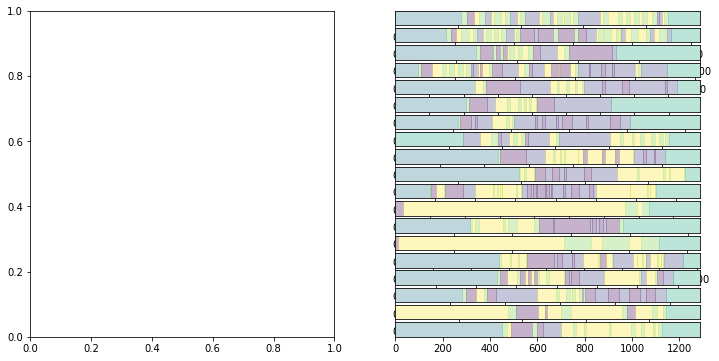

In [16]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


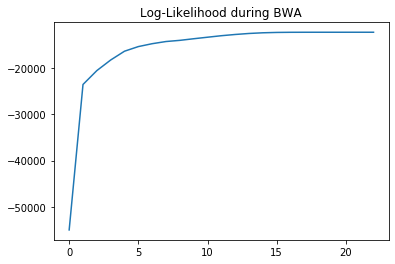

In [17]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

Model summary for state DX
-----------------------------------------
   Duration model
      NegativeBinomial: r=248.813, p=0.4831308057003353

   Emission model
      Categorical with weights=[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.56336800e-15 3.78225846e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.49567237e-14 9.53274382e-14 1.24014591e-02 9.87598541e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.56238388e-15 1.21492201e-14 0.00000000e+00 0.00000000e+00
 9.33221881e-14 1.66210281e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.06264234e-13 1.35084319e-14 0.00000000e+00 0.00000000e+00]
Model summary for state place_tool
---------------------------------------

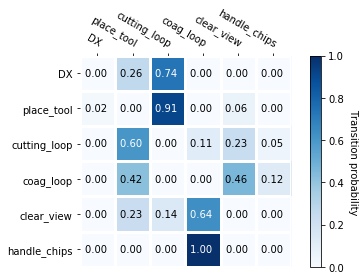

In [18]:
plt.close()
hsmm_model.total_summary(state_list)

<Figure size 432x288 with 0 Axes>

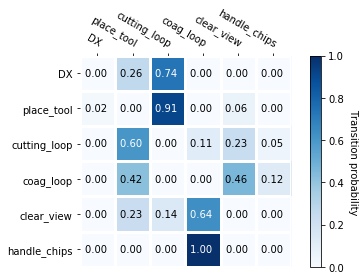

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure()
hsmm_model.plot_trans_distn(state_list)
plt.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

### 2e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [20]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 2f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [21]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 2g. Experiment Summary

The setup of the HSMM that was fitted in the previous action is the following

---

## 3. Further experiments